In [1]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib

import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [2]:
# def read_tejaas(filename):
#     rsidlist = list()
#     bplist   = list()
#     pvallist = list()
#     with open(filename, 'r') as instream:
#         next(instream)
#         for line in instream:
#             linesplit = line.strip().split()
#             rsid = linesplit[0]
#             bppos = int(linesplit[1])
#             pval = float(linesplit[5])
#             rsidlist.append(rsid)
#             bplist.append(bppos)
#             pvallist.append(pval)
#     return rsidlist, pvallist, bplist

from scipy import stats

def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    qscales = list()

    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            #pval = float(linesplit[5])
            
            qstat = float(linesplit[2])
            qmean = float(linesplit[3])
            qstd  = float(linesplit[4])
            if qstd > 0:
                qscale = (qstat - qmean) / qstd
            else:
                qscale = 0
            
            rsidlist.append(rsid)
            bplist.append(bppos)
            qscales.append(qscale)

    #pvalarr = 2.0 * (1 - stats.norm.cdf(np.abs(qscales)))
    pvalarr = 1 - stats.norm.cdf(np.array(qscales))
    pvallist = [x for x in pvalarr]
    return rsidlist, pvallist, bplist, qscales

In [3]:
resdir = "/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex/normalized/"
tissue = "esom"
#resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/lmcorrected"
#tisse = 'gtex-thy'

gwrsids = list()
gwpvals = list()
gwqscaled = list()
gwnsnps = dict()
gwbppos = dict()
for chrm in range(1, 7):
#for chrm in [1, 2, 6]:
    chrdir = "chr{:d}".format(chrm)
    srcdir = os.path.join(resdir, tissue)
    rrfile = os.path.join(srcdir, 'tejaas/permnull_sb0.05/{:s}/rr.txt'.format(chrdir))
    rsids, pvals, bplist, qscales = read_tejaas(rrfile)
    gwrsids += rsids
    gwpvals += pvals
    gwqscaled += qscales
    gwnsnps[chrm] = len(rsids)
    gwbppos[chrm] = np.array(bplist)

In [4]:
gwpvals = np.array(gwpvals)
pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
nonzero_pvals = gwpvals.copy()
nonzero_pvals[np.where(gwpvals == 0)] = pmax
gwlogpvals = -np.log10(nonzero_pvals)

gwqscaled = np.array(gwqscaled)

In [5]:
resdir = "/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex/normalized/"
tissue = "esom"

gwrsids2 = list()
gwpvals2 = list()
gwqscaled2 = list()
gwnsnps2 = dict()
gwbppos2 = dict()
for chrm in range(1, 7):
# for chrm in [1, 2, 6]:
    chrdir = "chr{:d}".format(chrm)
    srcdir = os.path.join(resdir, tissue)
    rrfile = os.path.join(srcdir, 'tejaas_rand/permnull_sb0.05/{:s}/rr.txt'.format(chrdir))
    rsids, pvals, bplist, qscales = read_tejaas(rrfile)
    gwrsids2 += rsids
    gwpvals2 += pvals
    gwqscaled2 += qscales
    gwnsnps2[chrm] = len(rsids)
    gwbppos2[chrm] = np.array(bplist)

In [6]:
gwpvals2 = np.array(gwpvals2)
pmax  = np.max(gwpvals2[np.where(gwpvals2 > 0)])
nonzero_pvals = gwpvals2.copy()
nonzero_pvals[np.where(gwpvals2 == 0)] = pmax
gwlogpvals2 = -np.log10(nonzero_pvals)

gwqscaled2 = np.array(gwqscaled2)

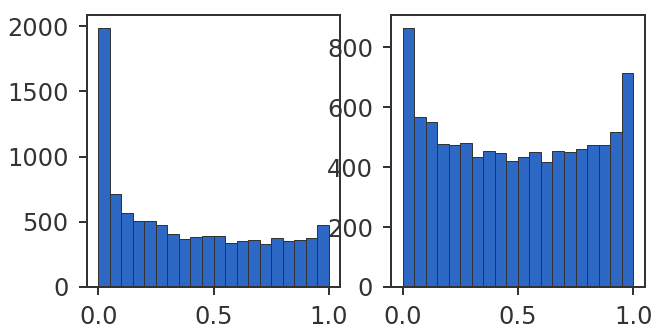

In [7]:
# Check the p-value distribution
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = 10000, replace = False))
ax1.hist(gwpvals[nchoose])
ax2.hist(gwpvals2[nchoose])
plt.show()

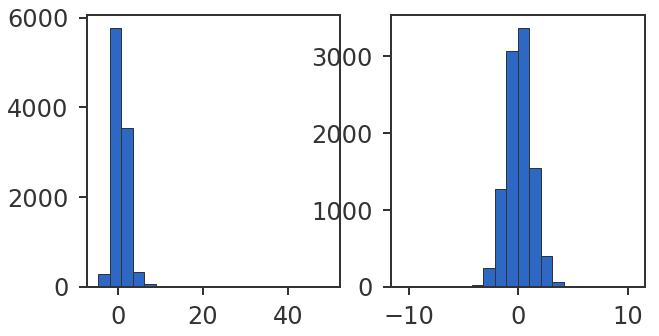

In [8]:
# Check the qscaled distribution
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = 10000, replace = False))
ax1.hist(gwqscaled[nchoose])
ax2.hist(gwqscaled2[nchoose])
plt.show()

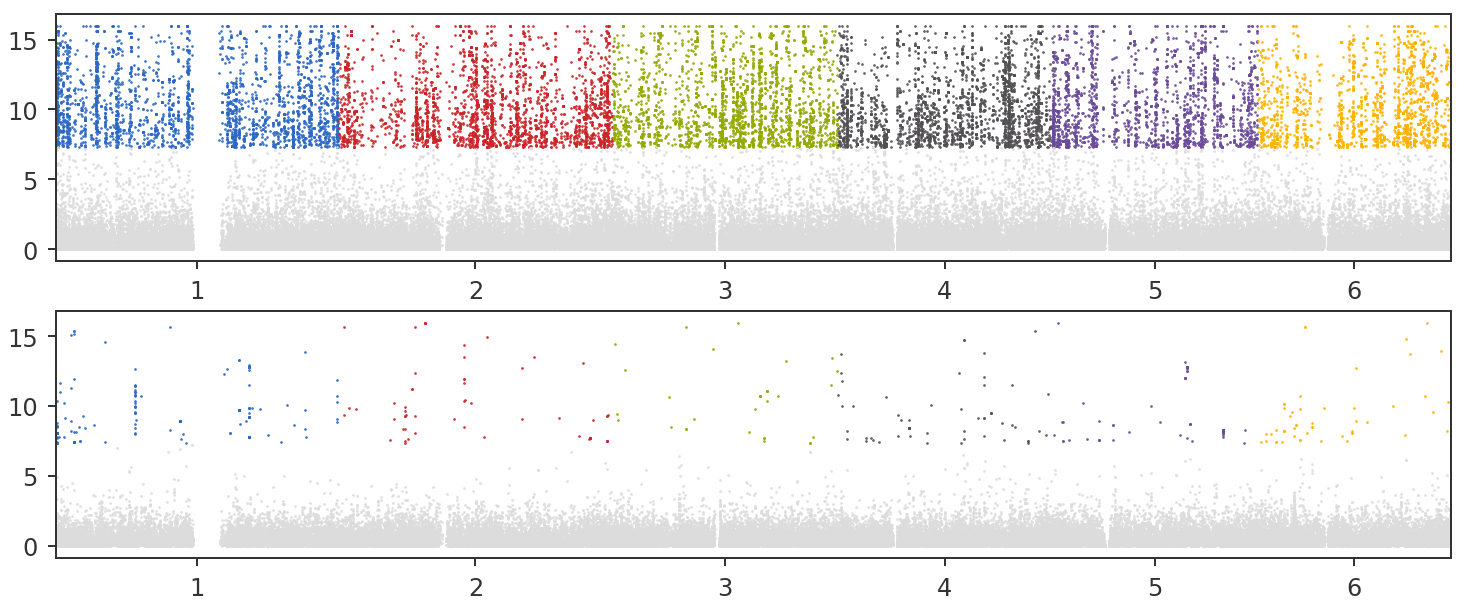

In [9]:
# Manhattan plot

fig = plt.figure(figsize = (25, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

logcutoff = -np.log10(5e-8)

i = 0
start = 0
lastbp = 0
xposlist = list()
chrmnums = np.arange(1,7)
# chrmnums = [1, 2, 6]
for chrm in chrmnums:
    end = start + gwnsnps[chrm]
    thisbp = gwbppos[chrm]
    xposlist.append(lastbp + int((thisbp[0] + thisbp[-1]) / 2))
    
    ## for tissue 1
    thislogp = gwlogpvals[start:end]
    nchoose = np.where(thislogp >= logcutoff)
    x = lastbp + thisbp[nchoose]
    ax1.scatter(x, thislogp[nchoose], alpha = 0.8, s = 3)
    nchoose = np.where(thislogp < logcutoff)
    nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
    x = lastbp + thisbp[nchoose_sparse]
    ax1.scatter(x, thislogp[nchoose_sparse], color='gainsboro', s = 3, alpha = 0.8)
    
    ## for tissue 2
    thislogp = gwlogpvals2[start:end]
    nchoose = np.where(thislogp >= logcutoff)
    x = lastbp + thisbp[nchoose]
    ax2.scatter(x, thislogp[nchoose], alpha = 0.8, s = 3)
    nchoose = np.where(thislogp < logcutoff)
    nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
    x = lastbp + thisbp[nchoose_sparse]
    ax2.scatter(x, thislogp[nchoose_sparse], color='gainsboro', s = 3, alpha = 0.8)

    start = end
    lastbp += thisbp[-1]

for ax in [ax1, ax2]:
    ax.set_xlim(0, lastbp)
    #ax.set_ylim(-1, 20)
    ax.set_xticks(xposlist)
    ax.set_xticklabels(chrmnums)

#outfile = '../plots/manhattan_as_sse_transeqtl_log10pvals_random.png'
#plt.savefig(outfile, bbox_inches='tight')

plt.show()

In [ ]:
np.where(gwlogpvals > logcutoff)[0].shape